### Dataset Preparation for YOLOv8 Instance Segmentation

In [63]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt

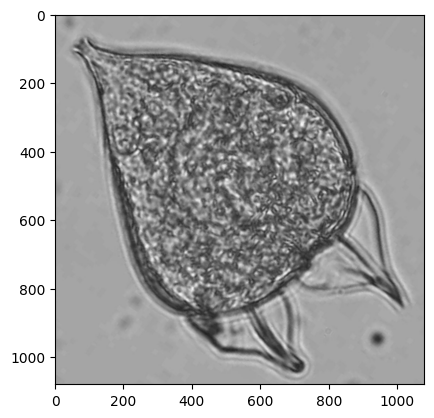

In [127]:
# Loading the image 
img = cv2.imread("/Users/mohammadbilal/Documents/Projects/STM32-InstanceSegmentation/base_model/assets/1.jpg")
assert img is not None, "File not found"  
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

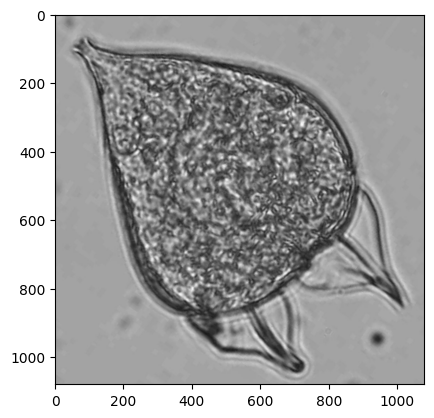

In [128]:
# Preprocessing code

from matplotlib.pyplot import gray


def resize(img, perc=0.5):
    """Utility function to resize the image"""
    width = int(img.shape[1] * perc)
    height = int(img.shape[0] * perc)
    resized = cv2.resize(img, (width, height), interpolation=cv2.INTER_AREA)
    return resized


def dark_channel(img, sz=15):
    """Calculates the dark channel in step 1"""
    b, g, r = cv2.split(img)
    dc = r - cv2.max(b, g)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (sz, sz))
    dark = cv2.erode(dc, kernel)
    return dark


def airlight(img, dc):
    """Calculates the air-light in step 4"""
    [h, w] = img.shape[:2]
    imgsz = h * w
    imgvec = img.reshape(imgsz, 3)
    dcvec = dc.reshape(imgsz)

    indices = dcvec.argsort()
    return imgvec[indices[0]]


def transmission_estimate(dc):
    """Calculates the transmission map as mentioned in step 2"""
    te = dc + (1 - np.max(dc))
    return te


def guided_filter(img, p, r, eps):
    """Helper function to refine the transmission"""
    mean_I = cv2.boxFilter(img, cv2.CV_64F, (r, r))
    mean_p = cv2.boxFilter(p, cv2.CV_64F, (r, r))
    mean_Ip = cv2.boxFilter(img * p, cv2.CV_64F, (r, r))
    cov_Ip = mean_Ip - mean_I * mean_p

    mean_II = cv2.boxFilter(img * img, cv2.CV_64F, (r, r))
    var_I = mean_II - mean_I * mean_I

    a = cov_Ip / (var_I + eps)
    b = mean_p - a * mean_I

    mean_a = cv2.boxFilter(a, cv2.CV_64F, (r, r))
    mean_b = cv2.boxFilter(b, cv2.CV_64F, (r, r))

    q = mean_a * img + mean_b
    return q


def transmission_refine(img, et):
    """Refines the transmission map as mentioned in step 3"""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = np.float64(gray) / 255
    r = 60
    eps = 0.0001
    t = guided_filter(gray, et, r, eps)
    return t


def recover(img, t, A):
    """Finally recovers the image using the image, the transmission map and air-light"""
    res = np.empty(img.shape, img.dtype)
    for index in range(0, 3):
        res[:, :, index] = (img[:, :, index] - A[index]) / t + A[index]

    return res

def dummy(x):
    pass

def normalize_image(img):
    """Utility function to normalize the intensities of the pixels in the image"""
    img = img - img.min()
    img = img / img.max() * 255
    img = np.uint8(img)
    return img

def edge_enhancement(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    img = clahe.apply(gray)

    kernel = np.array([[0,-1,0],
                   [-1,5,-1],
                   [0,-1,0]])
    img = cv2.filter2D(img, -1, kernel)
    img = cv2.fastNlMeansDenoising(img, None, h=10, templateWindowSize=7, searchWindowSize=21)
    edges = cv2.Canny(img, 50, 150)  # detect microorganism outlines

    # Dilate to thicken borders
    kernel = np.ones((3,3), np.uint8)
    edges = cv2.dilate(edges, kernel, iterations=1)

    # Overlay edges back to image
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    img[edges > 0] = [0, 0, 255]  # mark edges in red
    
    # Find contours from edges
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mask = np.zeros_like(img, dtype=np.uint8)

    cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)

    # Clean small noise blobs
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((5,5), np.uint8))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8))
    
    return mask

scale = 1
src = resize(img, scale)

img = src.astype('float64') / 255

ksize = 15
dc = dark_channel(img, ksize)
te = transmission_estimate(dc)
tr = transmission_refine(src, te)
A = airlight(img, tr)
result = recover(img, tr, A)
result = normalize_image(result)
mask = edge_enhancement(result)

img = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

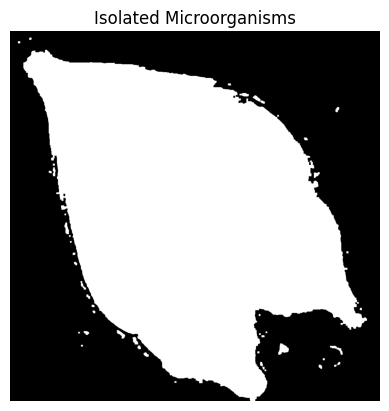

In [ ]:
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask)

# Create clean mask (ignore very small areas)
min_area = 5000  # adjust depending on organism size
clean_mask = np.zeros_like(mask)

for i in range(1, num_labels):  # skip background (label 0)
    if stats[i, cv2.CC_STAT_AREA] > min_area:
        clean_mask[labels == i] = 255

# ✅ Use clean_mask for bitwise_and
organism = cv2.bitwise_and(img, img, mask=clean_mask)
plt.imshow(cv2.cvtColor(organism, cv2.COLOR_BGR2RGB))  # Convert BGR → RGB
plt.title("Isolated Microorganisms")  # Set title separately
plt.axis("off")
plt.show()

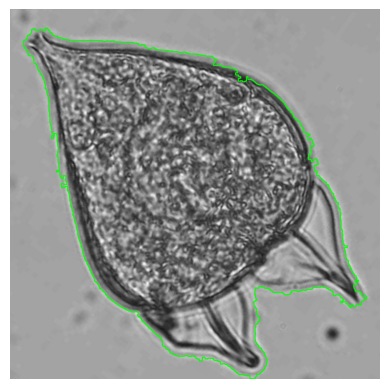

: 

In [ ]:

# Assume clean_mask is your binary mask (255 for organism, 0 for background)
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if contours:
    largest_contour = max(contours, key=cv2.contourArea)
    contours = [largest_contour]  
    
h, w = mask.shape[:2]
yolo_labels = []

class_id = 0  

for cnt in contours:
    polygon = []
    for point in cnt:
        x, y = point[0]
        x_norm = x / w
        y_norm = y / h
        polygon.extend([x_norm, y_norm])
    yolo_labels.append([class_id] + polygon)

overlay = img.copy()

# Draw contour in green
cv2.drawContours(overlay, [largest_contour], -1, (0,255,0), 2)

# Show the result
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

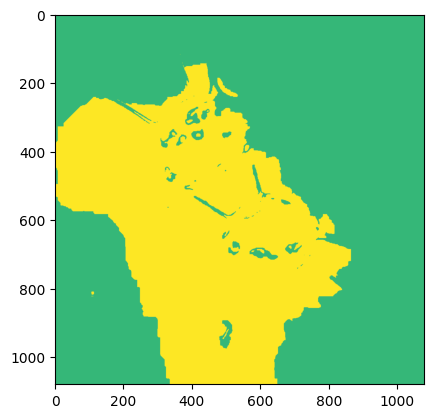

In [ ]:
h, w = img.shape[:2]
rect = (2, 2, w-2 , h-2) 
mask = np.zeros(img.shape[:2], np.uint8) # it is a mask image which stores the GrabCut Results
bgdModel = np.zeros((1,65), np.float64) # used by the algorithm internally
fgdModel = np.zeros((1,65), np.float64)

cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 20, cv2.GC_INIT_WITH_RECT) 

mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8') # Pixels with value 0 or 2 (definite/probable background) → 0 (background)
mask2 = mask2[:, :, np.newaxis] # adding the channel axis
result = img*mask2 # Multiplies image by mask (background pixels become black, foreground preserved)

plt.imshow(result)
plt.show()